# Avalon DataLab

<right>
<img src="https://www.allegiance.co.za/img/allegiance/allegiance_logo_new.png" width=180>
</right>

<h3 align="left"><font color='teal'>Read in data and prepare analytical environment</font></h3>

In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from sklearn.impute import SimpleImputer

# Suppress UserWarning from pandas
warnings.simplefilter(action='ignore', category=UserWarning)

# # Connect to SQL Server
conn = pyodbc.connect('DRIVER={SQL Server};'
                      'SERVER=db1-dev-int-jhb.avalon.co.za;'
                      'DATABASE=dev.avalon.libertygroup;'
                      'UID=AzureADAdmin;'
                      'PWD=@ll3g!Anc#.C).z@')
                      
# Retrieve data from SQL tables
df_clients = pd.read_sql_query('SELECT * FROM tbl_individual_clients', conn)
df_income = pd.read_sql_query('SELECT * FROM tbl_individual_income', conn)
df_liabilities = pd.read_sql_query('SELECT * FROM tbl_individual_liabilities', conn)
df_holdings = pd.read_sql_query('SELECT * FROM tbl_holdings', conn)
df_assets = pd.read_sql_query('SELECT * FROM tbl_individual_assets', conn)
df_users = pd.read_sql_query('SELECT * FROM tblusers', conn)

df_clients = df_clients[df_clients.gender != 'Joint']
df_clients = df_clients[df_clients.gender != 1]

# Clean and preprocess data
def clean_data(df_clients, df_income, df_liabilities):
    # Drop PII data
    df_clients = df_clients.drop(['firstname', 'surname', 'emailaddress'], axis=1)

#     # Merge data
#     df = pd.merge(df_clients, df_income, on='individualclientid')
#     df = pd.merge(df, df_liabilities, on='individualclientid')

#     # Rename columns
#     df = df.rename(columns={'age_x': 'age', 'amount_x': 'income', 'amount_y': 'liabilities'})

#     return df

# df = clean_data(df_clients, df_income, df_liabilities)



Initial EDA (unguided)

In [2]:
import dtale
import ipywidgets as widgets
from IPython.display import display

# Suppress FutureWarning from pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

clients = dtale.show(df_clients)

# Define the functions for each option
def option1():
    print("Viewing client data")
    dtale.show(df_clients)

def option2():
    print("Option 2 selected")
    # Code for option 2

def option3():
    print("Option 3 selected")
    # Code for option 3

# Create dropdown widget
dropdown = widgets.Dropdown(
    options=[('Clients', 1), ('Option 2', 2), ('Option 3', 3)],
    description='Select an option:'
)

# Create button widget
button = widgets.Button(description='Run Code')

# Create output widget
output = widgets.Output()

# Define event handlers
def dropdown_event_handler(change):
    with output:
        output.clear_output()
        option_value = change.new
        if option_value == 1:
            option1()
        elif option_value == 2:
            option2()
        elif option_value == 3:
            option3()

def button_event_handler(button):
    with output:
        output.clear_output()
        option_value = dropdown.value
        if option_value == 1:
            option1()
        elif option_value == 2:
            option2()
        elif option_value == 3:
            option3()

# Register event handlers
dropdown.observe(dropdown_event_handler, names='value')
button.on_click(button_event_handler)

# Display widgets
display(dropdown)
# display(button)
display(output)


Dropdown(description='Select an option:', options=(('Clients', 1), ('Option 2', 2), ('Option 3', 3)), value=1)

Output()

Ongoing EDA

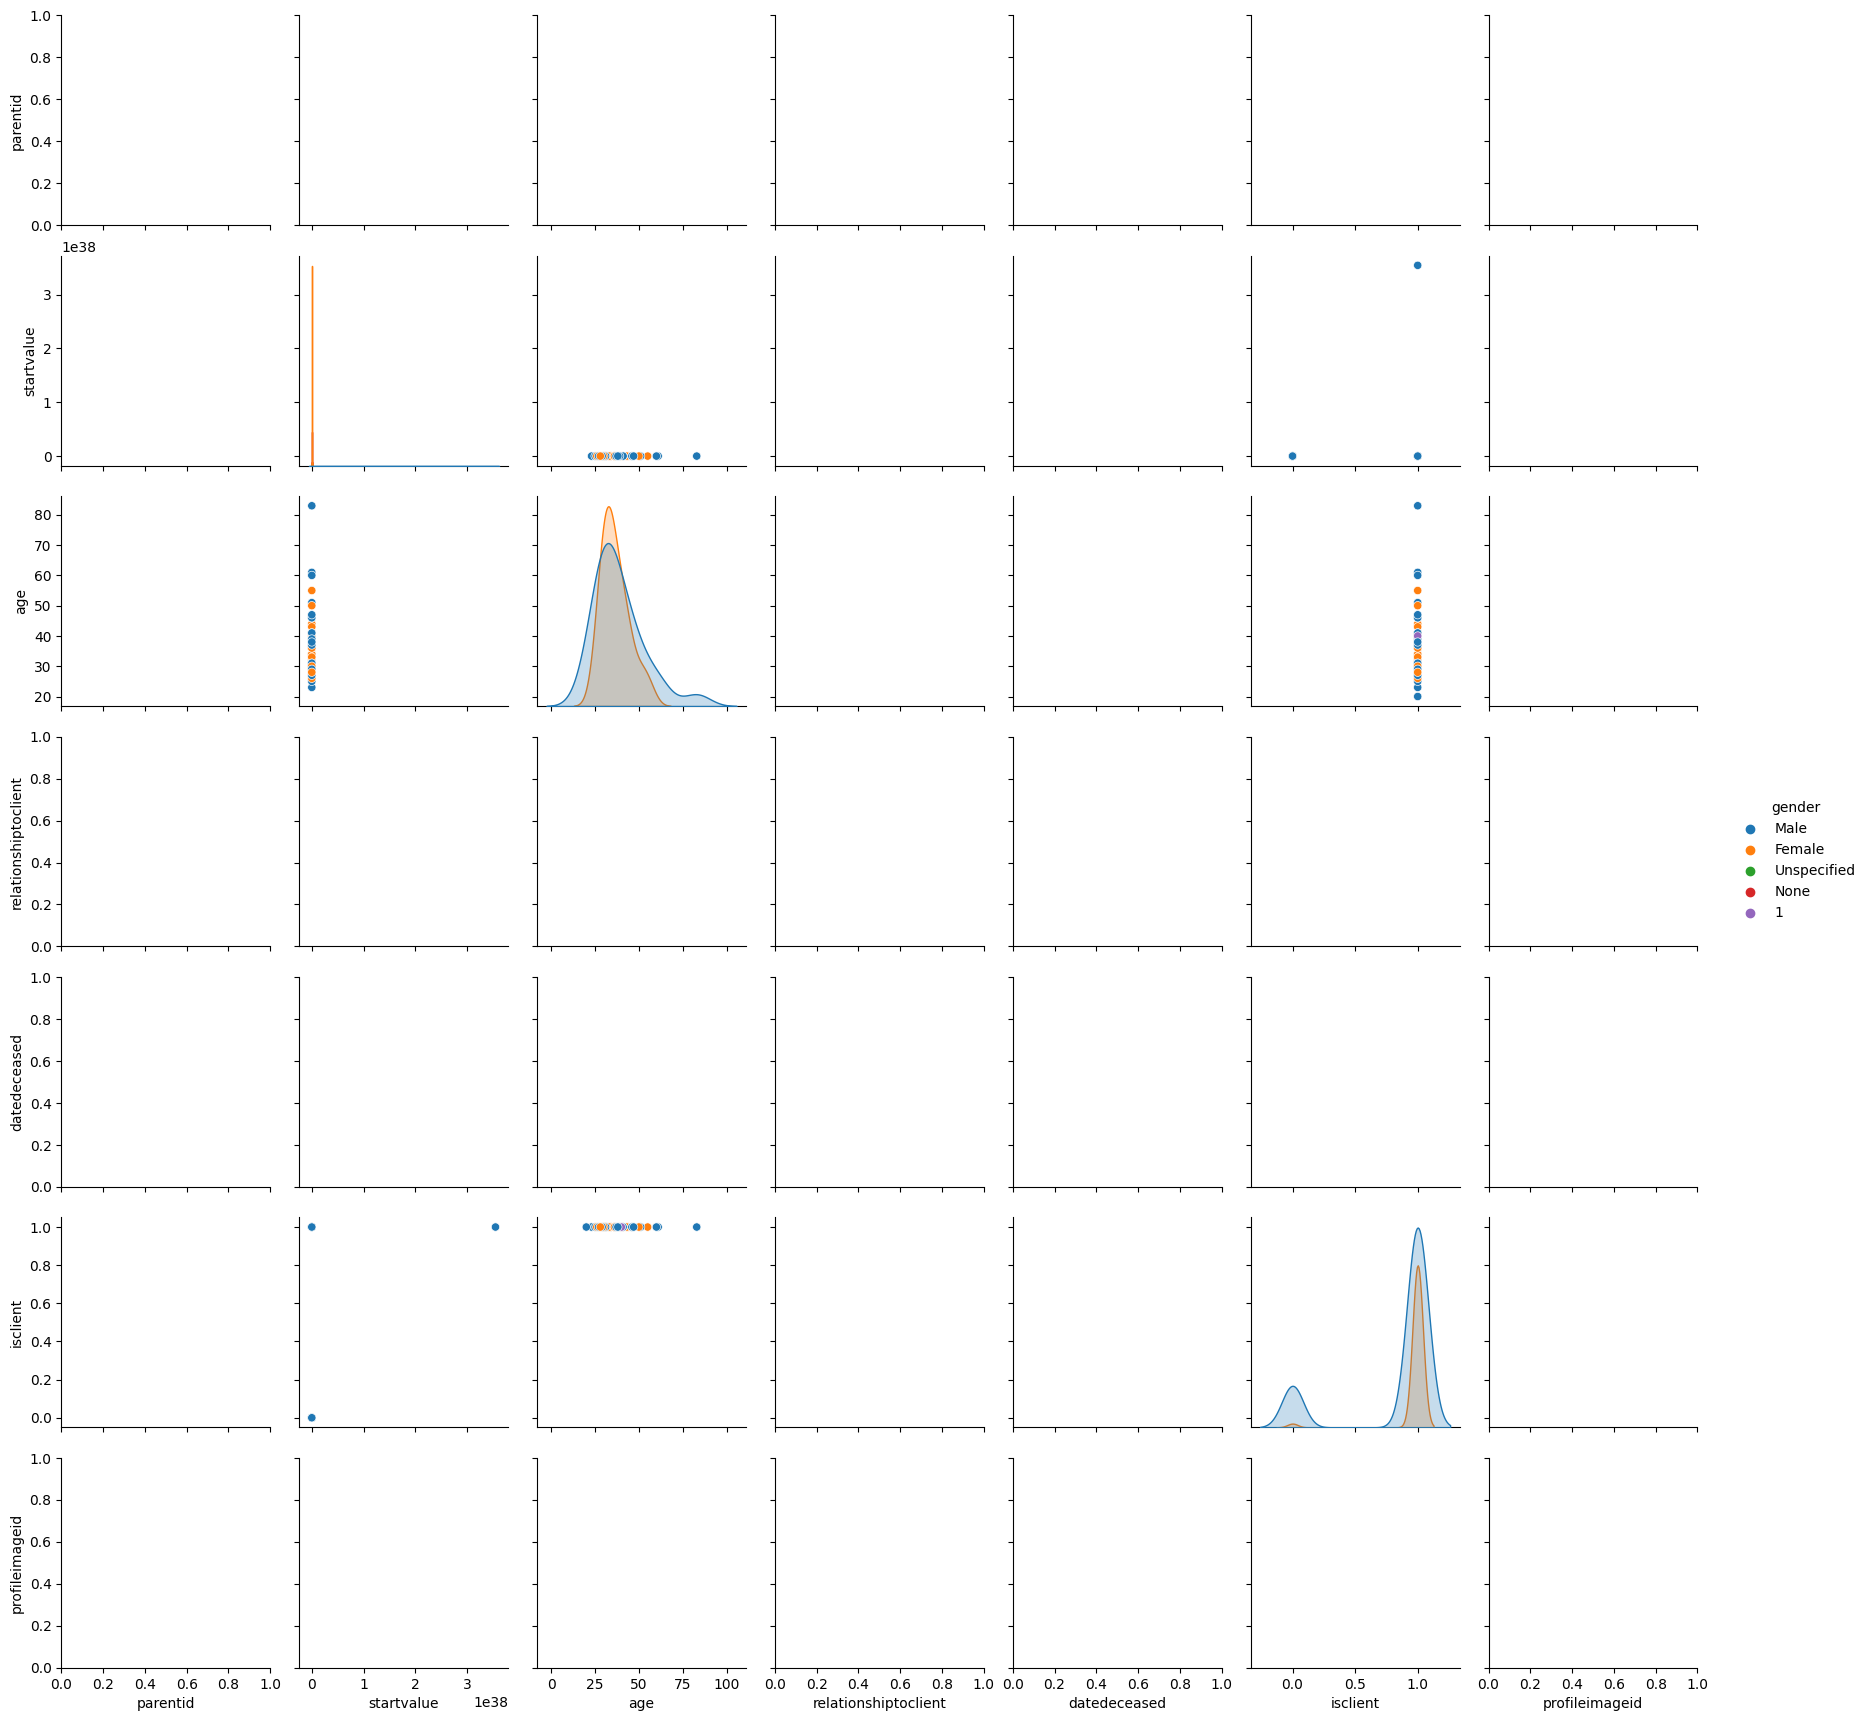

In [3]:
# Perform exploratory data analysis
sns.pairplot(df_clients, hue='gender')
plt.show()

# Convert categorical variables to numerical values using one-hot encoding
df_clients_encoded = pd.get_dummies(df_clients, columns=['maritalstatus'])

# Cluster data based on demographic groups
X = df_clients_encoded[['age', 'maritalstatus_Single', 'maritalstatus_Married', 'maritalstatus_Divorced']]
# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')
# Impute missing values in the X DataFrame
X = imputer.fit_transform(X)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(X)
df_clients['cluster'] = kmeans.labels_

# Analyze and correlate clustered data with investments
# Field names hidden for aesthetics
# print(df_clients.columns)
# print(df_holdings.columns)
# print(df_assets.columns)
df_holdings = df_holdings.rename(columns={'clientid': 'individualclientid'})
df_holdings_merged = pd.merge(df_holdings, df_clients, on='individualclientid')
df_assets_merged = pd.merge(df_assets, df_clients, on='individualclientid')

def plot_holdings_by_cluster():
    sns.catplot(x="cluster", y="holdingsvalue", kind="bar", data=df_holdings_merged)
    plt.show()

def plot_assets_by_cluster():
    sns.catplot(x="cluster", y="value", kind="bar", data=df_assets_merged)
    plt.show()


Analyzing incomes and liabilities across ages

In [4]:
### Dashboard prototype

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

# Load data
clients = df_clients
income = df_income
liabilities = df_liabilities

# Merge data
df = pd.merge(clients, income, on='individualclientid')
df = pd.merge(df, liabilities, on='individualclientid')

# Define the function to filter the data based on age and display a scatterplot
def plot_income_liabilities(min_age, max_age):
    try:
        filtered_df = df[(df['age'] >= min_age) & (df['age'] <= max_age)]
        sns.scatterplot(x='amount_x', y='debtamount', data=filtered_df)
        plt.show()
    except:
        print('Error: No data found for the specified age range.')

min_age_slider = widgets.IntSlider(value=0, min=0, max=100, description='min_age')
max_age_slider = widgets.IntSlider(value=100, min=0, max=100, description='max_age')
output = widgets.interactive_output(plot_income_liabilities, {'min_age': min_age_slider, 'max_age': max_age_slider})

display(min_age_slider, max_age_slider, output)

IntSlider(value=0, description='min_age')

IntSlider(value=100, description='max_age')

Output()

Analyzing demographics of clients per advisor

In [5]:
# Merge data
df_users = df_users.rename(columns={'User_ID': 'userid'})
df = pd.merge(df_clients, df_users, on='userid')

df_users['full_name'] = df_users['Name'].str.cat(df_users['Surname'], sep=' ')

print(df_users['full_name'])

# Assign codes to categorical variables
marital_status_codes = {'Married': 2, 'Single': 1, 'Divorced': 0, 'Widowed': -1}
df['maritalstatus_code'] = df['maritalstatus'].apply(lambda x: marital_status_codes[x] if x in marital_status_codes else None)

gender_codes = {'Male': 1, 'Female': 0}
df['gender_code'] = df['gender'].apply(lambda x: gender_codes[x] if x in gender_codes else None)

# Define function to get average demographics of clients for a user
def get_user_stats(user):
    user_clients = df[df['full_name'] == user]
    user_clients.dropna()
    avg_age = round(user_clients['age'].mean(),3)
    mode_marital_status_code = user_clients['maritalstatus_code'].mode().values[0] if not user_clients.empty else None
    mode_marital_status = next((k for k, v in marital_status_codes.items() if v == mode_marital_status_code), None)
    mode_gender_code = user_clients['gender_code'].mode().values[0] if not user_clients.empty else None
    mode_gender = next((k for k, v in gender_codes.items() if v == mode_gender_code), None)
    return {'Average Age': avg_age, 'Average Marital Status': mode_marital_status, 'Average Gender': mode_gender}

# Get list of unique user names
df_users = df_users.sort_values("Surname")
user_names = df_users['full_name'].unique().tolist()

# Create dropdown menu of user names
user_dropdown = widgets.Dropdown(options=user_names, description='Select a User')

# Define function to display average demographics for selected user
def display_user_stats(user):
    user_stats = get_user_stats(user)
    for stat, value in user_stats.items():
        print(f'{stat}: {value}')

# Tie dropdown menu to function that displays user stats
widgets.interactive(display_user_stats, user=user_dropdown)


0            NOREEN VAN ZYL
1           ZINHLE MALULEKE
2          YVONNE ALEXANDER
3               DAVID BEARD
4             MPHO NHLABANE
               ...         
2243      KENNETH WILKINSON
2244    Performance Testing
2245           GERT JORDAAN
2246          NICOLE NAIDOO
2247        TEBOGO RATSATSI
Name: full_name, Length: 2248, dtype: object


interactive(children=(Dropdown(description='Select a User', options=('AFSANA ABBUBAKER', 'ZAAHID ABDUL HAMID',…

Analyzing product types by demographic groups

In [6]:
# Merge data
# lst = [df_clients_holdings_assets_users]
# del df_clients_holdings_assets_users
# del lst
df_clients = df_clients.rename(columns={'clientid': 'individualclientid'})
df_clients_holdings_assets_users = pd.merge(df_clients, df_assets, on='individualclientid')
df_clients_holdings_assets_users = pd.merge(df_clients_holdings_assets_users, df_users, on='userid')
# df_clients_holdings_assets_users = pd.merge(df_clients, df_holdings, on='individualclientid')

# pd.set_option('display.max_columns', 100)
# print(df_clients_holdings_assets_users.sample(20))

# Assign codes to categorical variables
# marital_status_codes = {'Married': 2, 'Single': 1, 'Divorced': 0, 'Widowed': -1, np.nan: None, None: None}
# df_clients_holdings_assets_users['maritalstatus'] = df_clients_holdings_assets_users['maritalstatus'].str.replace(r'married.*', 'Married', case=False, regex=True)

# marital_status_dict = {'Single': 'Single', 'Divorced': 'Divorced', 'Married': 'Married', 'Widowed': 'Widowed', 'Separated': 'Separated', 'Registered Partnership': 'Registered Partnership', 'Other': 'Other', 'Engaged': 'Engaged', 'Common-Law Partnership': 'Common-Law Partnership', 'Domestic Partnership': 'Domestic Partnership'}
# df_clients_holdings_assets_users['maritalstatus'] = df_clients_holdings_assets_users['maritalstatus'].replace(marital_status_dict)

import pandas as pd
from fuzzywuzzy import process

# Define mapping
mapping = {
    'In community of property': 'In Community of Property',
    'In Community of Property Male': 'Married In Community of Property Male',
    'In Community of Property Female': 'Married In Community of Property Female',
    'Out of community of property without accrual': 'Married Out of Community of Property without Accrual',
    'Out of community of property without accrual Male': 'Married Out of Community of Property without Accrual Male',
    'Out of community of property without accrual Female': 'Married Out of Community of Property without Accrual Female',
    'Out Community of Property with Accrual Male': 'Married Out of Community of Property with Accrual Male',
    'Out Community of Property with Accrual Female': 'Married Out of Community of Property with Accrual Female',
    'Out of community of property with Accrual': 'Married Out of Community of Property with Accrual',
    'Common Law Male': 'Male Common Law',
    'Common Law Female': 'Female Common Law',
    'Divorced Male': 'Male Divorced',
    'Divorced Female': 'Female Divorced',
    'Divorced Joint': 'Joint Divorced',
    'Married Male': 'Male Married',
    'Married Female': 'Female Married',
    'Married (In community of property)': 'Married In Community of Property',
    'Married (Out of community of property without accrual)': 'Married Out of Community of Property without Accrual',
    'Single Male': 'Male Single',
    'Single Female': 'Female Single',
    'Widowed Male': 'Male Widowed',
    'Widowed Female': 'Female Widowed',
    'Engaged Male': 'Male Engaged',
    'Engaged Female': 'Female Engaged',
    'Married Out of Community of Property with Accrual': 'Married Out of Community of Property with Accrual'
}

# Convert column to string type
df_clients_holdings_assets_users['maritalstatus'] = df_clients_holdings_assets_users['maritalstatus'].astype(str)

# Apply fuzzy matching
df_clients_holdings_assets_users['maritalstatus'] = df_clients_holdings_assets_users['maritalstatus'].apply(lambda x: process.extractOne(x, mapping.keys())[0])

# Replace asset types with standardized asset types using mapping dictionary
df_clients_holdings_assets_users['maritalstatus'] = df_clients_holdings_assets_users['maritalstatus'].replace(mapping)

df_clients_holdings_assets_users['maritalstatus_code'] = df_clients_holdings_assets_users['maritalstatus'].apply(lambda x: marital_status_codes[x] if x in marital_status_codes else None)

# # Sense check
# print(df_clients_holdings_assets_users['maritalstatus_code'].tolist())

print(df_clients_holdings_assets_users['gender'].unique())

gender_codes = {'Male': 1, 'Female': 0, '': None, np.nan: None}
df_clients_holdings_assets_users['gender_code'] = df_clients_holdings_assets_users['gender'].apply(lambda x: gender_codes[x] if x in gender_codes else None)

# Defragment df
df_clients_holdings_assets_users = df_clients_holdings_assets_users.copy()

# # Remove the _x suffix from any column names
# df = df.rename(columns={col: col[:-2] for col in df_holdings.columns if col.endswith('_x')})

# Group data by demographics and product types
grouped_data = df_clients_holdings_assets_users.groupby(['maritalstatus_code', 'gender_code', 'type']).size().reset_index(name='count')

# Fill missing values with 0
grouped_data = grouped_data.fillna(0)

# # Not working
# # Check if grouped_data is empty
# if grouped_data.empty:
#     print('No data available for any group')
# else:
#     # Get most commonly bought products for each demographic group
#     for i, group in grouped_data.groupby(['maritalstatus_code', 'gender_code']):
#         if int(i[0]) in marital_status_codes and int(i[1]) in gender_codes:
#             print(f'Most commonly bought products for {marital_status_codes[int(i[0])]} {gender_codes[int(i[1])]}:')
#         else:
#             print('Invalid marital status code or gender code')

#         subgroup = group[group['count'] == group['count'].max()]
#         if subgroup.empty:
#             print('No data available for this group')

# #         else:
# #             print(subgroup)
    
# OR

# Determine most common holding type for each demographic group
marital_gender_assettype = df_clients_holdings_assets_users.groupby(['maritalstatus', 'gender'], group_keys=True)['type'].apply(lambda x: x.mode().values[0]).reset_index()

# # Method 1 - prints types only
# # Print results
# for index, row in marital_gender_assettype.iterrows():
#     if row['type'] == '':
#         print(f"No data available for {row['maritalstatus']} {row['gender']}")
#     else:
#         print(f"Most common asset type for {row['maritalstatus']} {row['gender']} is {row['type']}")

# # Method 2 - prints statements on most common asset types per category
# # Create a dictionary to map asset type codes to descriptions
# asset_type_dict = df_clients_holdings_assets_users[['type', 'description']].drop_duplicates().set_index('type')['description'].to_dict()

# # Print results
# for index, row in marital_gender_assettype.iterrows():
#     asset_type_desc = asset_type_dict.get(row['type'], 'No data available')
#     if asset_type_desc == 'No data available':
#         print(f"No data available for {row['maritalstatus']} {row['gender']}")
#     else:
#         asset_type_desc = asset_type_desc.split(':', 1)[-1].strip()  # remove anything before a colon
#         print(f"Most common asset type for {row['maritalstatus']} {row['gender']} is {asset_type_desc}")

# Method 3 - prints a nicely formulated table
from tabulate import tabulate

# Create a dictionary to map asset type codes to descriptions
asset_type_dict = df_clients_holdings_assets_users[['type', 'description']].drop_duplicates().set_index('type')['description'].to_dict()

# Create a list to store the table data
table_data = []

# Loop through the rows of marital_gender_assettype and append the formatted data to the table data list
for index, row in marital_gender_assettype.iterrows():
    asset_type_desc = asset_type_dict.get(row['type'], 'No data available')
    if asset_type_desc == 'No data available':
        table_data.append([row['maritalstatus'], row['gender'], asset_type_desc])
    else:
        table_data.append([row['maritalstatus'], row['gender'], asset_type_desc.split(':')[-1].strip()])

# Print the formatted table
print(tabulate(table_data, headers=['Marital Status', 'Gender', 'Most Common Asset Type']))

# Method 4 - pivot table and heatmap

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Create a new column with the asset type description for each row
marital_gender_assettype['asset_type_desc'] = marital_gender_assettype['type'].apply(lambda x: asset_type_dict.get(x, 'No data available'))

# Remove anything before the colon in the description column
marital_gender_assettype['asset_type_desc'] = marital_gender_assettype['asset_type_desc'].apply(lambda x: x.split(":")[-1].strip())

# Create a LabelEncoder to encode the asset_type_desc column
le = LabelEncoder()
marital_gender_assettype['asset_type_code'] = le.fit_transform(marital_gender_assettype['asset_type_desc'])

# Create a pivot table of the marital_gender_assettype dataframe
pt = pd.pivot_table(marital_gender_assettype, values='asset_type_code', index='maritalstatus', columns='gender', fill_value=0, aggfunc='max')

# Create a heatmap of the pivot table using the asset_type_code column as the values
ax = sns.heatmap(pt, annot=True, cmap='Blues', fmt='g', annot_kws={'size': 14}, cbar_kws={'label': 'Asset Type Code'})

# Get the ticklabels for the colorbar
cbar = ax.collections[0].colorbar
ticklabels = cbar.ax.get_yticklabels()

# Map the ticklabels to the asset_type_desc using the LabelEncoder
ticklabel_values = [int(t.get_text()) for t in ticklabels]
ticklabel_descriptions = le.inverse_transform(ticklabel_values)
cbar.ax.set_yticklabels(ticklabel_descriptions)

# Set the x and y axis labels
ax.set_xlabel('Gender')
ax.set_ylabel('Marital Status')

# Show the plot
plt.show()


KeyboardInterrupt: 

<div class="alert alert-block alert-info">
<b>Conclusion:</b> Insights here.
</div>